# Week ??? Exercises

**Solutions for the exercises**

In this exercise we will study the $k$-means task. Recall that, given an input dataset $\mathbf{X}$ and a set of centers $\mathbf{C}$, the $k$-means cost function is defined as $$L(\mathbf{X}, \mathbf{C}) = \sum_{x \in \mathbf{X}} \min_{c \in \mathbf{C}} ||x - c||^2.$$

We'll start with some theoretical exercises.

# Theoretical Exercises

1. Given a set of points $\mathbf{X} \in \mathbb{R}^{n \times d}$ and a set of centers $\mathbf{C} \in \mathbb{R}^{k \times d}$, we can define an assignment matrix $\mathbf{A} \in \mathbb{R}^{n \times k}$. This matrix is 1 at $i, j$ if $x_i$ is closest to center $c_j$ and 0 otherwise. Suppose we take a step of Lloyd's algorithm and $\mathbf{A}$ does not change. What can you say about the loss value if we keep doing iterations of Lloyd's algorithm? 
2. Prove that an optimal $k$-means solution always has each center set to the mean of the points assigned to it.
3. Assume $k > n$. Initialize $\mathbf{C}$ such that, for every point $x_i$, there exists a center $c_j$ that only has $x_i$ assigned to it. Prove that Lloyd's algorithm on this $\mathbf{X}$ and $\mathbf{C}$ will always converge to 0 cost.

For the next questions, assume that $k=3$ and we are given $\mathbf{X} \in \mathbb{R}^{5 \times 2} = \{(b, 0), (0, b), (0, 0), (-1, 0), (0, -1)\}$, for $b \gg 1$ (read: "$b$ much bigger than $1$").

4. What is the smallest loss that can be obtained?
    - soln: Your optimal clustering is to put one center on $(b, 0)$, one on $(0, b)$, and the remaining one between $(0, 0), (-1, 0)$ and $(0, -1)$.
5. What is the largest loss value that Lloyd's algorithm may converge to?
    - soln: The worst clustering that Lloyd's can converge to is to have one center serving both the $(0, b)$ and $(b, 0)$ points. 
6. Can you give an initialization that would lead to this?
    - soln: This would occur if, for example, your initialization started with the three centers at $(0, 0), (-1, 0)$ and $(0, -1)$. Then the center at $(0, 0)$ would be closest to both the points at $(0, b)$ and $(b, 0)$ and would end up accounting for both of those outliers.
7. Use the counterexample from above and argue that $k$-means++ should avoid the worst-case result of Lloyd's algorithm with random initialization.

### Looking forward

We will investigate variants of questions 4-7 through the rest of this exercise set. To do this, we will design two datasets -- one that is reasonable for Lloyd's algorithm and one that we expect will break Lloyd's algorithm. We will then see whether $k$-means++ can 'fix' Lloyd's algorithm on the 'bad' dataset.

We start by defining some helper functions:

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a random $k$-Means solution by sampling randomly from the input dataset.
def init_random(x, k):
    d = int(x.shape[1])
    random_samples = np.random.choice(len(x), k)
    return x[random_samples]

# Calculate the Euclidean distance between points a and b
def euc_dist(a, b):
    return np.sqrt(np.sum(np.square(a - b)))

In [71]:
#Plotting function
def plot_lloyds(x, all_centers=None):
    plt.scatter(x[:, 0], x[:, 1], alpha=0.8, s=10)
    if all_centers:
        colors = plt.get_cmap('Reds')(np.linspace(0, 1, len(all_centers)))
        for i, centers in enumerate(all_centers):
            if i == len(all_centers) - 1:
                m = '*'
            else:
                m = '.'
            if i > 0:
                for j in range(len(centers)):
                    plt.plot(
                        [centers[j][0], all_centers[i-1][j][0]],
                        [centers[j][1], all_centers[i-1][j][1]],
                        linewidth=1,
                        marker=m,
                        markersize=15 * (i+1)/len(all_centers),
                        color=colors[i],
                        markeredgecolor=colors[i],
                    )
    plt.show()

# Dataset descriptions:
We now define the datasets that we will be working with in this exercise. The first is an artificially bad dataset that is designed to 'break' Lloyd's algorithm with naive initialization. $\frac{1}{3}$ of the clusters in the bad dataset have many points while the remaining $\frac{2}{3}$ of the clusters have one point each. Consider that we can set these clusters as far apart as we want.

The second dataset is a 'well-clusterable' dataset. It is designed to have nice clusters that are easy to find. We expect that Lloyd's algorithm will perform reasonably well on this dataset.

In [72]:
np.random.seed(1234)
def create_artificial_bad_dataset(n, k=15, vert_spacing=100, horiz_spacing=None):
    """
    Create a dataset of k clusters where 1/3 of the clusters have many points.
    The other clusters each have size 1 point.
    All clusters have small variance, so they are 'tightly packed'.
    Lloyd's algorithm should perform arbitrarily poorly on this dataset.
    """
    if k % 3 != 0:
        raise ValueError("Artificial bad dataset needs k to be divisible by 3")
    if horiz_spacing is None:
        horiz_spacing = 6 * vert_spacing / k
    
    # assume dimensionality is 2 so it's easy to plot
    points = np.zeros((n, 2))
    for column in range(int(k/3)):
        x = horiz_spacing * column
        points[int(column * 3 * n / k)] = [column * horiz_spacing, vert_spacing]
        points[int((column+1) * 3 * n / k - 1)] = [column * horiz_spacing, -vert_spacing]
        points[int(column * 3 * n / k + 1) : int((column+1) * 3 * n / k - 1)] = np.random.multivariate_normal([column * horiz_spacing, 0], [[1, 0], [0, 1]], [int(3 * n / k - 2)]) 
        
    return points

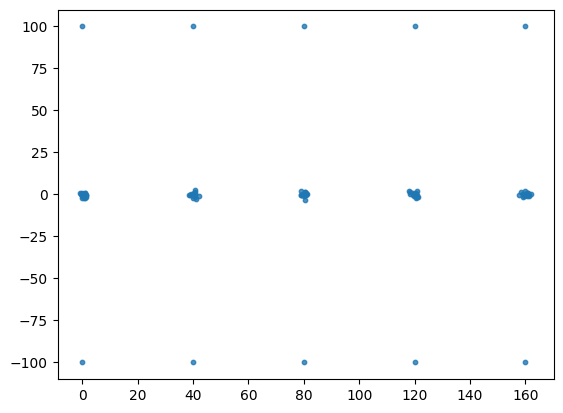

In [73]:
# Plot the artificially bad dataset
artificial_bad_x = create_artificial_bad_dataset(100)
plot_lloyds(artificial_bad_x)

In [74]:
np.random.seed(1234)
def create_hierarchical_clusters(n, point=None, std_dev=100, d=2, recur_likelihood=1.0):
    """
    Create a dataset that samples from a Gaussian distribution.
    For each sample, recursively sample points from its neighborhood with some likelihood.
    In expectation, this creates a normally distributed ball of Gaussian clusters
        such that each cluster likely has sub-clusters within it.
    """
    if point is None:
        point = np.zeros(d)
    if n <= 1:
        return np.random.multivariate_normal(point, np.eye(d) * std_dev, 1)
    
    points = []
    points_remaining = n
    i = 0
    while points_remaining > 1:
        subcluster_size = int(np.random.uniform() * points_remaining)
        if np.random.uniform() < recur_likelihood:
            subcluster_mean = np.random.multivariate_normal(point, np.eye(d) * std_dev)
            subcluster = create_hierarchical_clusters(
                n=subcluster_size,
                point=subcluster_mean,
                std_dev=std_dev/10,
                d=d,
                recur_likelihood=recur_likelihood * np.random.uniform()
            )
        else:
            subcluster = np.random.multivariate_normal(point, np.eye(d) * std_dev, subcluster_size)
        points.append(subcluster)
        points_remaining -= subcluster_size
            
    if points:
        points = np.concatenate(points, axis=0)
        if len(points) > n:
            points = points[np.random.choice(len(points), n)]
        return points
    return np.empty([0, d])

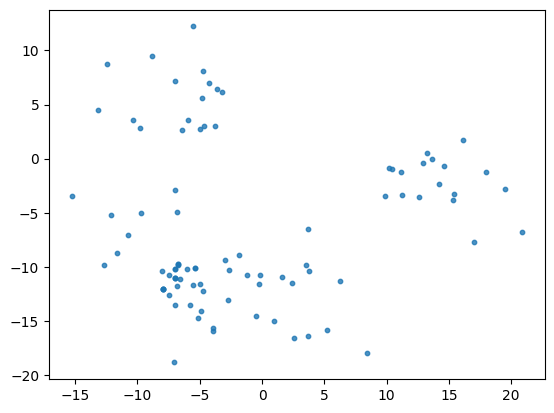

In [75]:
well_clusterable_x = create_hierarchical_clusters(100, d=2)
plot_lloyds(well_clusterable_x)

# Lloyd's Algorithm
We will now implement Lloyd's algorithm. This will be done in several sub-methods that we implement first:

In [76]:
def get_assignments(points, centers):
    '''
    Return a vector of length n where the i-th value says which center x_i is assigned to.
    For example, if the first point is closest to the fifth center, then assignments[0] = 4.
    '''
    assignments = -1 * np.ones(len(points))
    
    # Tip: we defined a function for the euclidean distance in the first cell of this notebook.
    ### YOUR CODE HERE
    for i, point in enumerate(points):
        min_dist = np.inf
        closest_center = None
        for j, center in enumerate(centers):
            point_center_dist = euc_dist(point, center)
            if point_center_dist < min_dist:
                min_dist = point_center_dist
                closest_center = j
        assignments[i] = closest_center
    ### END CODE

    return assignments.astype(np.int32)

def score(points, centers):
    '''
    Given points and centers, return the total cost of the kmeans objective
    '''
    assignments = get_assignments(points, centers)
    cost = 0
    
    ### YOUR CODE HERE
    for i, point in enumerate(points):
        cost += np.square(euc_dist(point, centers[assignments[i]]))
    ### END CODE
    
    return cost

def lloyds_step(points, centers):
    '''
    Given the points and centers, get the new set of centers.
    This means that we:
        1. Find which points are closest to each center using the get_assignments() method above
        2. Find the mean of each cluster
        3. Update each center to the mean of its cluster
    '''
    n, d = points.shape
    k = centers.shape[0]
    assignments = get_assignments(points, centers)
    new_centers = np.zeros((k, d))
    
    # Assign new centers to the means of the clusters
    # Tip: consider using np.where(assignments == c) to find the indices of the points that belong to center c
    #                                                for 0 <= c < k
    ### YOUR CODE HERE
    for c in range(len(centers)):
        point_inds = np.where(assignments == c)
        new_centers[c] = np.mean(points[point_inds], axis=0)
    ### END CODE
        
    return new_centers


We now put these methods together into Lloyd's algorithm:

In [77]:
def lloyds(x, k, init, tol=1e-8, max_steps=1000, loud=True):
    all_centers = [init(x, k)]
    step = 0
    cost = score(x, all_centers[-1])
    loss_change = np.inf
    while loss_change > tol and step < max_steps:
        # Do a step of Lloyd's algorithm and evaluate our new loss
        new_centers = lloyds_step(x, all_centers[-1])
        new_cost = score(x, new_centers)
        loss_change = cost - new_cost
        cost = new_cost
        
        step += 1
        all_centers.append(new_centers)
        if loud:
            print(cost)
        
    return all_centers

### Visualization Description:
When plotting Lloyd's algorithm, we represent the final set of centers with stars. We then use a streak of red lines to show how the centers moved. The printed values are the loss values at each step.

1351.2564559310358
822.1930789745581
802.6873582339374
768.2118373052051
762.7310638422713
760.2665321006123
760.2665321006123


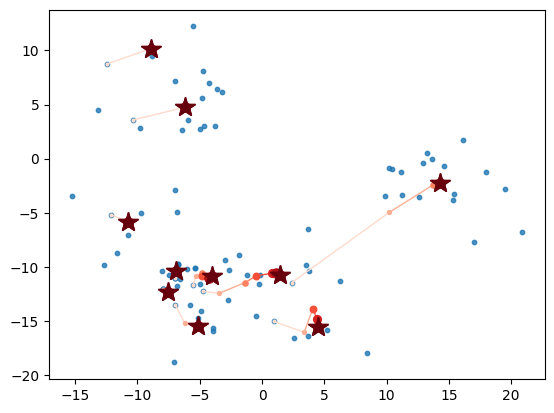

In [78]:
all_centers = lloyds(well_clusterable_x, 10, init_random)
plot_lloyds(well_clusterable_x, all_centers)

69758.50828850485
6258.203700498128
4956.330768068694
4956.330768068694


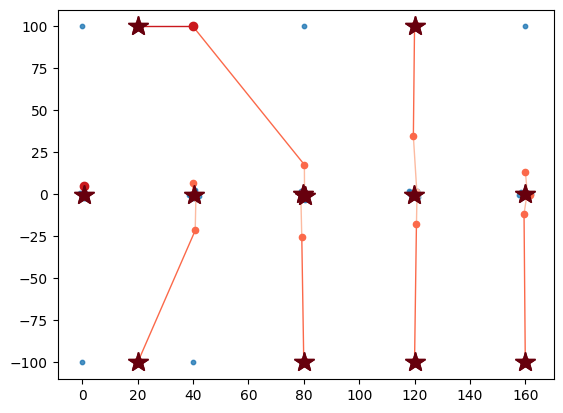

In [79]:
k = 15
all_centers = lloyds(artificial_bad_x, k, init_random)
plot_lloyds(artificial_bad_x, all_centers)

# $k$-Means++
Next, we will implement $k$-means++. Recall that $k$-means++ initializes center $c_i$ based on the distances of the points to centers $c_1$ through $c_{i-1}$. More specifically, given a set of points $\mathbf{X}$ and a set of $l$ centers $\mathbf{C}$, we define a probability distribution:
$$ p(x_i) = \frac{\min_{c \in \mathbf{C}} ||x_i - c||^2}{\sum_{x \in \mathbf{X}} \min_{c \in \mathbf{C}} ||x - c||^2}. $$

We then sample the next center from the set of points based on this probability distribution. The first center is chosen uniformly at random from $\mathbf{X}$.

## Questions:
- Is a point ever going to get sampled twice?
- Suppose there are $n-2$ points at the origin, one point at (0, 1) and another at (1, 0). How many steps of Lloyd's algoirthm are required to guarantee 0 loss if we use $k$-means++ initialization with $k=3$?
    - soln: 0 steps of Lloyd's algorithm are required. Each of the three clusters will be hit perfectly.

In [86]:
def get_min_dists_to_centers(points, new_center, dists):
    '''
    Return distances of points to centers given a new center.
    
    If the i-th point has distance 10 to its closest center, then dists[i] = 10.
    
    Since we are given the distances of the points to the old centers, we are simply interested in which
        points are closest to the new center and updating the dists accordingly.
    '''
    if dists is None:
        # dists = None when we had no centers before. Distance to closest center is then inf
        dists = np.ones((len(points))) * np.inf
    if len(new_center.shape) == 1:
        new_center = np.expand_dims(new_center, axis=0)
        
    ### YOUR CODE HERE
    new_dists = np.sum((points - new_center) ** 2, axis=-1)
    improved_inds = new_dists < dists
    dists[improved_inds] = new_dists[improved_inds]
    ### END CODE
    
    return dists

def init_kmeans_plusplus(points, k):
    '''
    Initialize a set of k centers using k-means++
    '''
    n, d = int(points.shape[0]), int(points.shape[1])
    # np.random.choice(n, p) selects from n items according to probability distribution p
    centers = [np.random.choice(n)]
    sq_dists = None
    
    ### YOUR CODE HERE
    for i in range(k-1):
        sq_dists = get_min_dists_to_centers(points, points[np.array(centers)[-1]], sq_dists)
        prob_dist = sq_dists / np.sum(sq_dists)
        centers.append(np.random.choice(n, p=prob_dist))
    ### END CODE
    
    return points[centers]

## Comparing $k$-Means++ and Random Initialization

We now compare the results of $k$-means++ and random initialization with Lloyd's algorithm.

### Well-Clusterable Data
We start with plots on the well-clusterable data. The printed values are the loss values during each step of Lloyd's algorithm.

1620.3160175071653
994.4718852323144
900.1982284116117
826.0321710144017
740.0289224718413
719.435411946552
691.5436432999592
667.443138284527
666.1390296774276
666.1390296774276


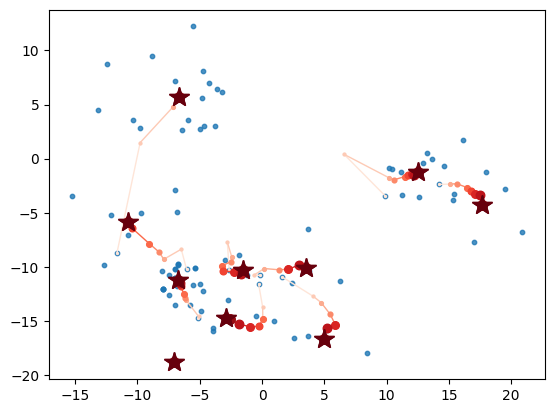

742.8044262441827
681.5269185305789
650.7863375767689
642.0371399564284
636.2992456608357
636.2992456608357


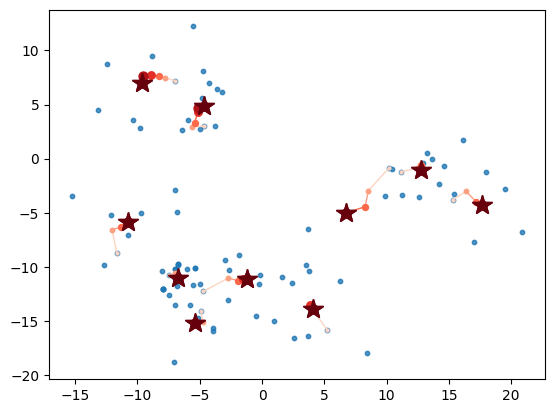

In [87]:
all_centers = lloyds(well_clusterable_x, 10, init_random)
plot_lloyds(well_clusterable_x, all_centers)

all_centers = lloyds(well_clusterable_x, 10, init_kmeans_plusplus)
plot_lloyds(well_clusterable_x, all_centers)

### Artificially bad data
Now we compare Lloyd's algorithm with $k$-means++ vs. random initialization on the artificially bad dataset. Note the loss values at the end of Lloyd's convergence.

62921.602777948545
3347.5406240270604
3347.048846967109
3347.048846967109


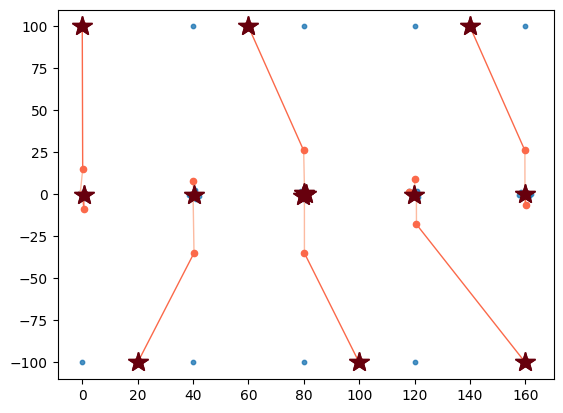

165.6050779629256
165.6050779629256


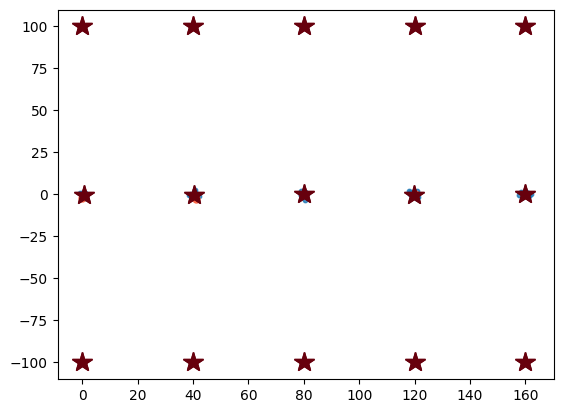

In [88]:
all_centers = lloyds(artificial_bad_x, 15, init_random)
plot_lloyds(artificial_bad_x, all_centers)

all_centers = lloyds(artificial_bad_x, 15, init_kmeans_plusplus)
plot_lloyds(artificial_bad_x, all_centers)

## Runtime analysis

*** FIXME -- could do theory question looking at the cost as function of sum of distances within a cluster. Then JL makes sense to run from a theory setup ***

Lastly, we compare the runtimes and losses for three different ways of running $k$-means on high-dimensional data. One is simply with Lloyd's algorithm on a randomly initialized dataset, one is with $k$-means++ (without Lloyd's algorithm), and the last is with $k$-means++ on data that has been transformed by a Johnson-Lindenstrauss projection. We compare the losses and runtimes of each.

In [66]:
# Look at runtime distribution for Lloyds and KMeans++ with and without JL
from time import time
from sklearn.random_projection import SparseRandomProjection
n, d, k = 1000, 800, 100
num_experiments = 3
times = np.zeros((3, num_experiments))
costs = np.zeros((3, num_experiments))

print('Experiment iteration counter:')
JL = SparseRandomProjection(30).fit(np.ones((n, d)))
for i in range(num_experiments):
    print('{}...'.format(i))
    x = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)
    start = time()
    all_centers = lloyds(x, k, init_random, loud=False)
    end = time()
    times[0, i] = end - start
    print(end - start)
    costs[0, i] = score(x, all_centers[-1])

    start = time()
    all_centers = init_kmeans_plusplus(x, k)
    end = time()
    times[1, i] = end - start
    print(end - start)
    costs[1, i] = score(x, all_centers[-1])

    start = time()
    x = JL.transform(x)
    middle = time()
    all_centers = init_kmeans_plusplus(x, k)
    end = time()
    print(middle - start)
    times[2, i] = end - start
    costs[2, i] = score(x, all_centers[-1])
    print()
    
print('Random init --- time: {:.3f} +/- {:.3f}; cost: {:.3f}'.format(np.mean(times[0]), np.var(times[0]), np.mean(costs[0]), np.var(costs[0])))
print('kmeans++ init --- time: {:.3f} +/- {:.3f}; cost: {:.3f}'.format(np.mean(times[1]), np.var(times[1]), np.mean(costs[1]), np.var(costs[1])))
print('JL and kmeans++ init --- time: {:.3f} +/- {:.3f}; cost: {:.3f}'.format(np.mean(times[2]), np.var(times[2]), np.mean(costs[2]), np.var(costs[2])))

Experiment iteration counter:
0...


/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


6.291980743408203
0.08111286163330078
0.0015521049499511719

1...


/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


3.4799840450286865
0.08131694793701172
0.0013499259948730469

2...


/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/au698373/phd/venvs/phd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


6.234922885894775
0.08163285255432129
0.001783609390258789

Random init --- time: 5.336 +/- 1.722; cost: 713364.204
kmeans++ init --- time: 0.081 +/- 0.000; cost: 799924.063
JL and kmeans++ init --- time: 0.010 +/- 0.000; cost: 777330.524
